# Deep Generative Models: Autoencoder and GANs to Generate Faces

Data: CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with celebrity images, each with 40 attribute annotations. The dataset was accessed through the following link: https://www.kaggle.com/jessicali9530/celeba-dataset

Three approaches will be taken in the following:     

**Autoencoder:** An autoencoder compresses its input down to a vector - with much fewer dimensions than its input data, and then transforms it back into a tensor with the same shape as its input over several neural net layers. They are trained to reproduce their input. This was adapted from Coursera's Advanced Machine Learning Bayesian course. 

**GAN:** A GAN, instead of compressing high dimensional data, it has low dimensional vectors as the inputs, high dimensional data in the middle. Instead of being given a bit of data as input, it is given a small vector of random numbers. The generator network tries to transform this vector into a realistic sample from the training data. The discriminator network then takes this generated sample (and some real samples from the dataset) and learns to guess whether the samples are real or fake. More precisely itis trained to minimise cross entropy between the probability it outputs and a vector of *0s* for fake images and “1”s for real images. The generator learns to make more convincing samples (or minimise the cross entropy between the discriminators guess about it’s creations and “1”). Inspired by and adapted from https://fairyonice.github.io/My-first-GAN-using-CelebA-data.html

**VAE-GAN:** Similar to GANs, but their generators are VAEs. This is the model specified in the paper of Larsen et. al. (2016) (https://arxiv.org/pdf/1512.09300.pdf).

## Variational Autoencoder

In [1]:
import shutil
import errno
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#extract data downloaded from https://www.kaggle.com/jessicali9530/celeba-dataset
zip_ref = zipfile.ZipFile('celeba-dataset.zip','r')
zip_ref.extractall()
zip_ref.close()

### Custom Image Generator

A workaround for the large size of the data and potential issues encountered with loading it into the Jupyter Notebook memory, is to use a stream generator, which streams batches of data into memory sequentially, limiting the amount of memory required for the function. The code for this was taken from https://medium.com/@ensembledme/writing-custom-keras-generators-fe815d992c5a

In [2]:
#data generator - source https://medium.com/@ensembledme/writing-custom-keras-generators-fe815d992c5a
from skimage.io import imread

def get_input(path):
    """get specific image from path"""
    img = imread(path)
    return img

def get_output(path, label_file = None):
    """get all the labels relative to the image of path"""
    img_id = path.split('/')[-1]
    labels = label_file.loc[img_id].values
    return labels

def preprocess_input(img):
    # convert between 0 and 1
    return img.astype('float32') / 127.5 -1

def image_generator(files, label_file, batch_size = 32):
    while True:

        batch_paths = np.random.choice(a = files, size = batch_size)
        batch_input = []
        batch_output = []

        for input_path in batch_paths:

            input = get_input(input_path)
            input = preprocess_input(input)
            output = get_output(input_path, label_file = label_file)
            batch_input += [input]
            batch_output += [output]
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        yield batch_x, batch_y

def auto_encoder_generator(files, batch_size = 32):
    while True:
        batch_paths = np.random.choice(a = files, size = batch_size)
        batch_input = []
        batch_output = []

        for input_path in batch_paths:
            input = get_input(input_path)
            input = preprocess_input(input)
            output = input
            batch_input += [input]
            batch_output += [output]
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        yield batch_x, batch_y

### Attribute data

In [3]:
#load attributes
import pandas as pd
attr = pd.read_csv('list_attr_celeba.csv')
attr = attr.set_index('image_id')

#check attributes successfully loaded
attr.describe()

5_o_Clock_Shadow  Arched_Eyebrows    Attractive  Bags_Under_Eyes  \
count     202599.000000    202599.000000  202599.00000    202599.000000   
mean          -0.777728        -0.466039       0.02501        -0.590857   
std            0.628602         0.884766       0.99969         0.806778   
min           -1.000000        -1.000000      -1.00000        -1.000000   
25%           -1.000000        -1.000000      -1.00000        -1.000000   
50%           -1.000000        -1.000000       1.00000        -1.000000   
75%           -1.000000         1.000000       1.00000        -1.000000   
max            1.000000         1.000000       1.00000         1.000000   

                Bald          Bangs       Big_Lips       Big_Nose  \
count  202599.000000  202599.000000  202599.000000  202599.000000   
mean       -0.955113      -0.696849      -0.518408      -0.530935   
std         0.296241       0.717219       0.855135       0.847414   
min        -1.000000      -1.000000      -1.000000      -1.000000   
25%        -1.000000      -1.000000      -1.000000      -1.000000   
50%        -1.000000      -1.000000      -1.000000      -1.000000   
75%        -1.000000      -1.000000      -1.000000      -1.000000   
max         1.000000       1.000000       1.000000       1.000000   

          Black_Hair     Blond_Hair  ...      Sideburns        Smiling  \
count  202599.000000  202599.000000  ...  202599.000000  202599.000000   
mean       -0.521498      -0.704016  ...      -0.886979      -0.035839   
std         0.853255       0.710186  ...       0.461811       0.999360   
min        -1.000000      -1.000000  ...      -1.000000      -1.000000   
25%        -1.000000      -1.000000  ...      -1.000000      -1.000000   
50%        -1.000000      -1.000000  ...      -1.000000      -1.000000   
75%        -1.000000      -1.000000  ...      -1.000000       1.000000   
max         1.000000       1.000000  ...       1.000000       1.000000   

       Straight_Hair      Wavy_Hair  Wearing_Earrings    Wearing_Hat  \
count  202599.000000  202599.000000      202599.00000  202599.000000   
mean       -0.583196      -0.360866          -0.62215      -0.903079   
std         0.812333       0.932620           0.78290       0.429475   
min        -1.000000      -1.000000          -1.00000      -1.000000   
25%        -1.000000      -1.000000          -1.00000      -1.000000   
50%        -1.000000      -1.000000          -1.00000      -1.000000   
75%        -1.000000       1.000000          -1.00000      -1.000000   
max         1.000000       1.000000           1.00000       1.000000   

       Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie          Young  
count     202599.000000     202599.000000    202599.000000  202599.000000  
mean          -0.055129         -0.754066        -0.854570       0.547234  
std            0.998482          0.656800         0.519338       0.836982  
min           -1.000000         -1.000000        -1.000000      -1.000000  
25%           -1.000000         -1.000000        -1.000000       1.000000  
50%           -1.000000         -1.000000        -1.000000       1.000000  
75%            1.000000         -1.000000        -1.000000       1.000000  
max            1.000000          1.000000         1.000000       1.000000  

[8 rows x 40 columns]

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

IMG_NAME_LENGTH = 6
file_path = "img_align_celeba/"
img_id = np.arange(1,len(attr.index)+1)
img_path = []
for i in range(len(img_id)):
    img_path.append(file_path + (IMG_NAME_LENGTH - len(str(img_id[i])))*'0' + str(img_id[i]) + '.jpg')
    
#80:20 train:test split
train_path = img_path[:int((0.8)*len(img_path))]
val_path = img_path[int((0.8)*len(img_path)):]
train_generator = auto_encoder_generator(train_path,32)
val_generator = auto_encoder_generator(val_path,32)

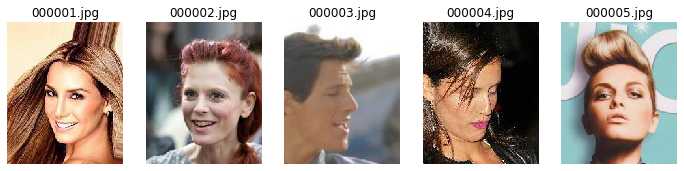

5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
image_id                                                                     
000001.jpg                -1                1           1               -1   
000002.jpg                -1               -1          -1                1   
000003.jpg                -1               -1          -1               -1   
000004.jpg                -1               -1           1               -1   
000005.jpg                -1                1           1               -1   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
image_id                                                             ...   
000001.jpg    -1     -1        -1        -1          -1          -1  ...   
000002.jpg    -1     -1        -1         1          -1          -1  ...   
000003.jpg    -1     -1         1        -1          -1          -1  ...   
000004.jpg    -1     -1        -1        -1          -1          -1  ...   
000005.jpg    -1     -1         1        -1          -1          -1  ...   

            Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
image_id                                                                     
000001.jpg         -1        1              1         -1                 1   
000002.jpg         -1        1             -1         -1                -1   
000003.jpg         -1       -1             -1          1                -1   
000004.jpg         -1       -1              1         -1                 1   
000005.jpg         -1       -1             -1         -1                -1   

            Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
image_id                                                                       
000001.jpg           -1                 1                -1               -1   
000002.jpg           -1                -1                -1               -1   
000003.jpg           -1                -1                -1               -1   
000004.jpg           -1                 1                 1               -1   
000005.jpg           -1                 1                -1               -1   

            Young  
image_id           
000001.jpg      1  
000002.jpg      1  
000003.jpg      1  
000004.jpg      1  
000005.jpg      1  

[5 rows x 40 columns]

In [5]:
#sanity check of images and atributes
fig, ax = plt.subplots(1, 5, figsize=(12, 20))
for i in range(5):    
    ax[i].imshow(get_input(img_path[i]))
    ax[i].axis('off')
    ax[i].set_title(img_path[i][-10:])
plt.show()
    
attr.iloc[:5]

### Building and Training a VAE Model

First, a Convolutional VAE Model (including encoder and decoder) will be created and compiled for the celebrity faces dataset.

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.


In [11]:
#model architecture

b_size = 128
n_size = 512
img_sample = get_input(img_path[1])

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape = (n_size,) , mean = 0, stddev = 1)
    return z_mean + K.exp(z_log_sigma/2) * epsilon
  
def build_conv_vae(input_shape, bottleneck_size, sampling, batch_size = 32):
    
    #ENCODER
    input = Input(shape=(input_shape[0],input_shape[1],input_shape[2]))
    x = Conv2D(32,(3,3),activation = 'relu', padding = 'same')(input)    
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(64,(3,3),activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(128,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(256,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    
    #Latent Variable Calculation
    shape = K.int_shape(x)
    flatten_1 = Flatten()(x)
    dense_1 = Dense(bottleneck_size, name='z_mean')(flatten_1)
    z_mean = BatchNormalization()(dense_1)
    flatten_2 = Flatten()(x)
    dense_2 = Dense(bottleneck_size, name ='z_log_sigma')(flatten_2)
    z_log_sigma = BatchNormalization()(dense_2)
    z = Lambda(sampling)([z_mean, z_log_sigma])
    encoder = Model(input, [z_mean, z_log_sigma, z], name = 'encoder')
    
    #DECODER
    latent_input = Input(shape=(bottleneck_size,), name = 'decoder_input')
    x = Dense(shape[1]*shape[2]*shape[3])(latent_input)
    x = Reshape((shape[1],shape[2],shape[3]))(x)
    x = UpSampling2D((2,2))(x)
    x = Cropping2D([[0,0],[0,1]])(x)
    x = Conv2DTranspose(256,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Cropping2D([[0,1],[0,1]])(x)
    x = Conv2DTranspose(128,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Cropping2D([[0,1],[0,1]])(x)
    x = Conv2DTranspose(64,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    output = Conv2DTranspose(3,(3,3), activation = 'tanh', padding ='same')(x)
    decoder = Model(latent_input, output, name = 'decoder')

    output_2 = decoder(encoder(input)[2])
    vae = Model(input, output_2, name ='vae')
    return vae, encoder, decoder, z_mean, z_log_sigma

vae, encoder, decoder, z_mean, z_log_sigma = build_conv_vae(img_sample.shape, n_size, sampling, batch_size = b_size)
print("encoder summary:")
encoder.summary()
print("decoder summary:")
decoder.summary()
print("vae summary:")
vae.summary()

encoder summary:
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 218, 178, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 218, 178, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 218, 178, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 109, 89, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________

In [12]:
#define VAE loss function
def vae_loss(input_img, output):
    #compute error in reconstruction
    reconstruction_loss = mse(K.flatten(input_img) , K.flatten(output))
    
    #compute KL Divergence regularisation term
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = -1)
    
    #return average loss over all images in batch
    total_loss = (reconstruction_loss + 0.0001 * kl_loss)    
    return total_loss

In [13]:
#compile model
vae.compile(optimizer='rmsprop', loss = vae_loss)
encoder.compile(optimizer = 'rmsprop', loss = vae_loss)
decoder.compile(optimizer = 'rmsprop', loss = vae_loss)

In [15]:
#train the model
vae.fit_generator(train_generator, steps_per_epoch = 100, validation_data = val_generator, epochs = 100, validation_steps = 20)

Epoch 1/100
100/100 [==============================] - 570s 6s/step - loss: 0.0819 - val_loss: 0.0852
Epoch 2/100
100/100 [==============================] - 575s 6s/step - loss: 0.0783 - val_loss: 0.0815
Epoch 3/100
100/100 [==============================] - 614s 6s/step - loss: 0.0763 - val_loss: 0.0774
Epoch 4/100
100/100 [==============================] - 574s 6s/step - loss: 0.0734 - val_loss: 0.0780
Epoch 5/100
100/100 [==============================] - 571s 6s/step - loss: 0.0687 - val_loss: 0.0810
Epoch 6/100
100/100 [==============================] - 570s 6s/step - loss: 0.0684 - val_loss: 0.0665
Epoch 7/100
100/100 [==============================] - 592s 6s/step - loss: 0.0670 - val_loss: 0.0782
Epoch 8/100
100/100 [==============================] - 584s 6s/step - loss: 0.0646 - val_loss: 0.0619
Epoch 9/100
100/100 [==============================] - 582s 6s/step - loss: 0.0623 - val_loss: 0.0576
Epoch 10/100
100/100 [==============================] - 584s 6s/step - loss: 0.061

100/100 [==============================] - 559s 6s/step - loss: 0.0395 - val_loss: 0.0315
Epoch 81/100
100/100 [==============================] - 560s 6s/step - loss: 0.0390 - val_loss: 0.0332
Epoch 82/100
100/100 [==============================] - 563s 6s/step - loss: 0.0392 - val_loss: 0.0370
Epoch 83/100
100/100 [==============================] - 557s 6s/step - loss: 0.0391 - val_loss: 0.0359
Epoch 84/100
100/100 [==============================] - 557s 6s/step - loss: 0.0392 - val_loss: 0.0360
Epoch 85/100
100/100 [==============================] - 560s 6s/step - loss: 0.0382 - val_loss: 0.0362
Epoch 86/100
100/100 [==============================] - 558s 6s/step - loss: 0.0386 - val_loss: 0.0332
Epoch 87/100
100/100 [==============================] - 558s 6s/step - loss: 0.0385 - val_loss: 0.0356
Epoch 88/100
100/100 [==============================] - 559s 6s/step - loss: 0.0380 - val_loss: 0.0342
Epoch 89/100
100/100 [==============================] - 562s 6s/step - loss: 0.0377 - 

In [16]:
#save trained model weights
vae.save_weights('CelebA_VAE.h5')

### Visualise

Some images of the training set will be chosen at random, run through the encoder to parameterise the latent code, and then reconstructed with the decoder

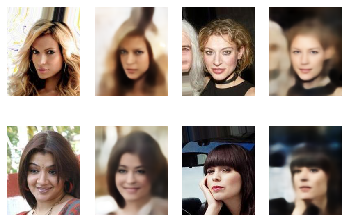

In [17]:
import random
x_test = []
for i in range(64):
    x_test.append(get_input(img_path[random.randint(0,len(img_id))]))

x_test = np.array(x_test)
figure_Decoded = vae.predict(x_test.astype('float32')/127.5 -1, batch_size = b_size)
figure_original = x_test[0]
figure_decoded = (figure_Decoded[0]+1)/2
for i in range(4):
    plt.axis('off')
    plt.subplot(2,4,1+i*2)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.subplot(2,4,2 + i*2)
    plt.imshow((figure_Decoded[i]+1)/2)
    plt.axis('off')
plt.show()

Reconstructed images look similar to the originals, but are blurry - a known feature of VAE reconstructions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


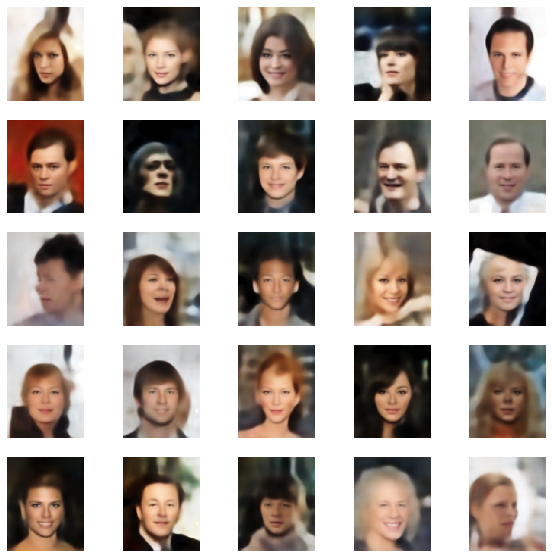

In [22]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.axis('off')
    plt.subplot(5, 5, i+1)
    plt.imshow((figure_Decoded[i]+1)/2)
    plt.axis('off')

### Latent Space Representation

The latent space representations of images can be plotted. Some differences between the latent codes are seen, which may explain the differences between the original images.

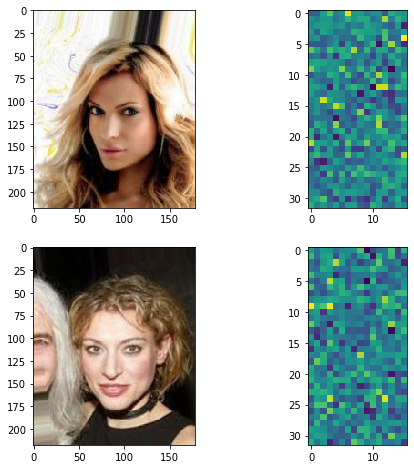

In [23]:
# Choose two images of different attributes, and plot the original and latent space of it

x_test1 = []
for i in range(64):
    x_test1.append(get_input(img_path[np.random.randint(0,len(img_id))]))
x_test1 = np.array(x_test)
x_test_encoded = np.array(encoder.predict(x_test1/127.5-1, batch_size = b_size))
figure_original_1 = x_test[0]
figure_original_2 = x_test[1]
Encoded1 = (x_test_encoded[0,0,:].reshape(32, 16,)+1)/2 
Encoded2 = (x_test_encoded[0,1,:].reshape(32, 16)+1)/2

plt.figure(figsize=(8, 8))
plt.subplot(2,2,1)
plt.imshow(figure_original_1)
plt.subplot(2,2,2)
plt.imshow(Encoded1)
plt.subplot(2,2,3)
plt.imshow(figure_original_2)
plt.subplot(2,2,4)
plt.imshow(Encoded2)
plt.show()

### Sampling from Latent Space

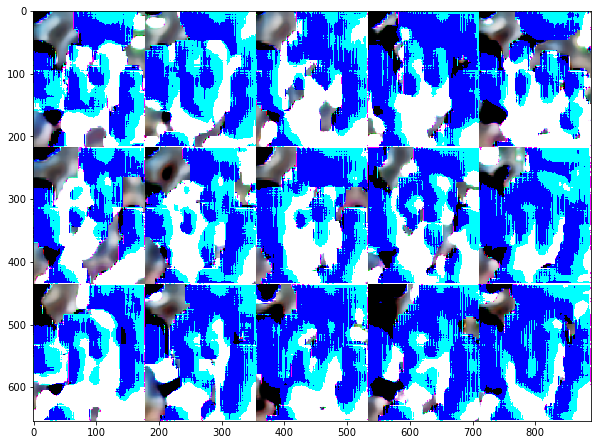

In [37]:
#randomly generate 15 images from 15 series of noise information
n = 3
m = 5
digit_size1 = 218
digit_size2 = 178
figure = np.zeros((digit_size1 * n, digit_size2 * m,3))
 
for i in range(3):
    for j in range(5):
        z_sample = np.random.rand(1,512)
        x_decoded = decoder.predict([z_sample])
        #x_decoded = np.clip(x_decoded, 0, 1)
        figure[i * digit_size1: (i + 1) * digit_size1,
               j * digit_size2: (j + 1) * digit_size2,:] = np.clip((x_decoded[0]+1)/2, 0, 1)
    
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

### Generating faces with desired characteristics

This function was adapted from the Advanced Machine Learning course on Coursera. It randomly generates 10 initial samples, which the user rates based on the desired characteristics/similarity with expected feature image, that they want (e.g. darkest hair, rank the 10 pictures in order of darkest hair to lightest). The function then generates candidate image, using binary search to find best match location in the original array and insert it, its new score is the average of its neighbours. In the corner case, where there is no left neighbour, it uses 10 as the left neighbour score. And in the corner case where there is no right neighbour, it uses 0 as the right neighbour score. The limitation of this function is that it relies on the original feature order array, and initial sorting can affect the final result significantly. Also, to assign a new score, time complexity is O(log(n)) where n is array size.

Unlike the original code, the test set was used to generate random samples select images and the VAE was used to generate images, rather than generating samples independently from the decoder. The reason for this is, as shown above, the decoder is not particularly good at generating images that can be used to distinguish features to rate. To run on the decoder alone, the model may require optimisation and/or more epochs to train and/or more data to train on.

In [198]:
import tensorflow as tf
import GPy
import GPyOpt

In [200]:
class FacialComposit:
    def __init__(self, decoder, vae, latent_size):
        self.latent_size = latent_size
        self.vae = vae
        self.decoder = decoder
        self.samples = None
        self.images = None
        self.rating = None

    def _get_image(self, latent):
        #img = self.decoder.predict(np.random.normal(0,1,size=(1, self.latent_size)))
        
        #generate x_test predictions and randomly select an image
        num = random.randrange (0,64,1)
        img = vae.predict(x_test.astype('float32')/127.5 -1)
        img = np.clip((img[num]+1)/2, 0, 1)
        return img

    @staticmethod
    def _show_images(images, titles):
        assert len(images) == len(titles)
        plt.figure(figsize=(3*len(images), 3))
        n = len(titles)
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.imshow(images[i])
            plt.title(str(titles[i]))
            plt.axis('off')
        plt.show()

    @staticmethod
    def _draw_border(image, w=2):
        bordered_image = image.copy()
        bordered_image[:, :w] = [1, 0, 0]
        bordered_image[:, -w:] = [1, 0, 0]
        bordered_image[:w, :] = [1, 0, 0]
        bordered_image[-w:, :] = [1, 0, 0]
        return bordered_image

    def query_initial(self, n_start=10, select_top=10):
        '''
        Creates initial points for Bayesian optimisation
        Generate *n_start* random images and asks user to rank them.
        Gives maximum score to the best image and minimum to the worst.
        :param n_start: number of images to rank initialy.
        :param select_top: number of images to keep
        '''
        samples = np.random.randn(n_start, self.latent_size)
        images = np.array([self._get_image(samples[i]) for i in range(n_start)])
        self._show_images(images, ["Image{}".format(i) for i in range(n_start)])
        print("Please select top {} that's most similar to expected image, input index(zero based) list separated by space.".format(select_top))
        ranks = list(map(int, input().split()))
        self.samples = samples[ranks] 
        self.images = images[ranks] 
        self.rating = np.arange(10, 0, -10/(1 + select_top))[1:] 
        
    def compare(self, candidate_image, current_image):
        self._show_images([candidate_image, current_image], ['candidate image', 'current image'])
        print("Is the candidate image better than current image? [y/n]")
        response = input().lower()
        assert response in ['y', 'n'], "Only input 'y' or 'n'."
        return response == 'y'

    def evaluate(self, candidate):
        '''
        Queries candidate vs known image set.
        Adds candidate into images pool.
        :param candidate: latent vector of size 1xlatent_size
        '''
        initial_size = len(self.images)

        #show user an image and ask to assign score to it.
        candidate = candidate[0]
        candidate_image = self._get_image(candidate)
        low = 0
        high = initial_size
        while low < high:
            mid = (low + high) // 2
            if self.compare(candidate_image, self.images[mid]):
                high = mid
            else:
                low = mid + 1
                
        if low == 0:
            candidate_rating = (10 + self.rating[0]) / 2
        elif low == initial_size:
            candidate_rating = (self.rating[-1] + 0) / 2
        else:
            candidate_rating = (self.rating[low - 1] + self.rating[low]) / 2
        
        self.samples = np.insert(self.samples, low, candidate, axis=0)
        self.images = np.insert(self.images, low, candidate_image, axis=0)
        self.rating = np.insert(self.rating, low, candidate_rating, axis=0)
        
        assert len(self.images) == initial_size + 1
        assert len(self.rating) == initial_size + 1
        assert len(self.samples) == initial_size + 1
        return candidate_rating

    def optimize(self, n_iter=10, w=4, acquisition_type='MPI', acquisition_par=0.3):
        if self.samples is None:
            self.query_initial()

        bounds = [{'name': 'z_{0:03d}'.format(i),
                   'type': 'continuous',
                   'domain': (-w, w)} 
                  for i in range(self.latent_size)]
        optimizer = GPyOpt.methods.BayesianOptimization(f=self.evaluate, domain=bounds,
                                                        acquisition_type = acquisition_type,
                                                        acquisition_par = acquisition_par,
                                                        exact_eval=False, #we are not sure
                                                        model_type='GP',
                                                        X=self.samples,
                                                        Y=self.rating[:, None],
                                                        maximize=True)
        optimizer.run_optimization(max_iter=n_iter, eps=-1)

    def get_best(self):
        index_best = np.argmax(self.rating)
        return self.images[index_best]

    def draw_best(self, title=''):
        index_best = np.argmax(self.rating)
        image = self.images[index_best]
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        plt.show()

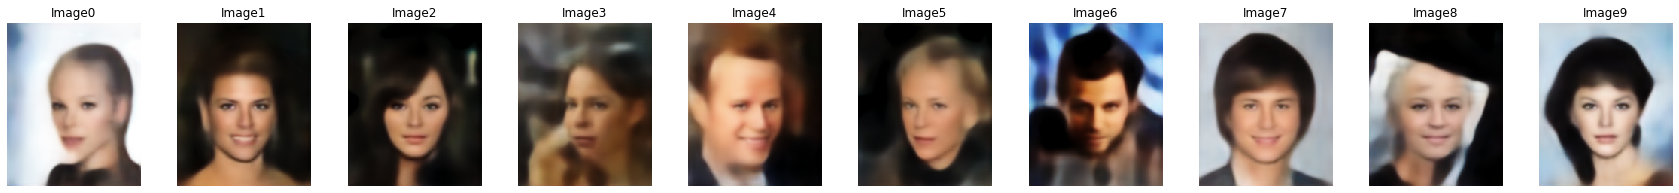

Please select top 10 that's most similar to expected image, input index(zero based) list separated by space.
6 2 1 9 7 3 4 0 5 8


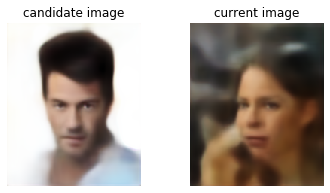

Is the candidate image better than current image? [y/n]
y


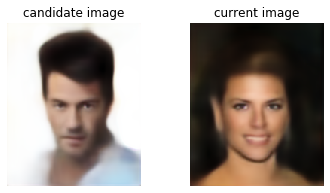

Is the candidate image better than current image? [y/n]
y


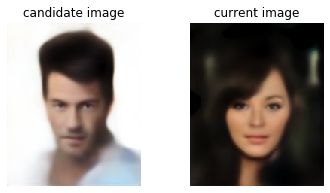

Is the candidate image better than current image? [y/n]
n


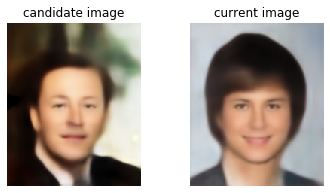

Is the candidate image better than current image? [y/n]
y


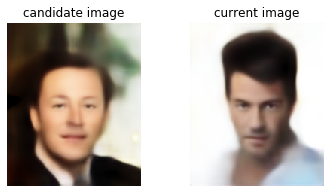

Is the candidate image better than current image? [y/n]
n


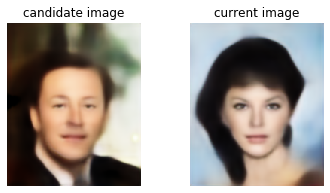

Is the candidate image better than current image? [y/n]
n


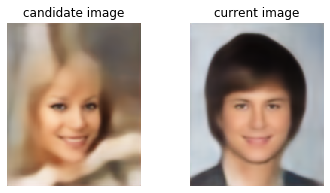

Is the candidate image better than current image? [y/n]
n


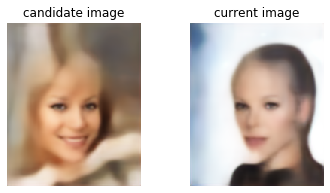

Is the candidate image better than current image? [y/n]
n


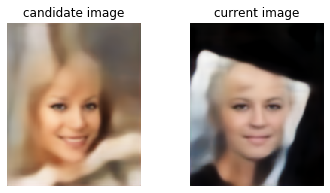

Is the candidate image better than current image? [y/n]
y


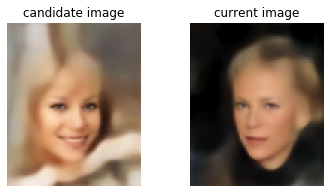

Is the candidate image better than current image? [y/n]
n


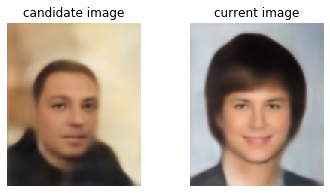

Is the candidate image better than current image? [y/n]
n


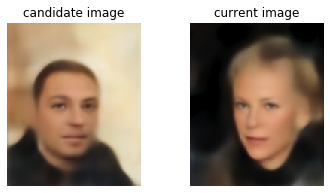

Is the candidate image better than current image? [y/n]
y


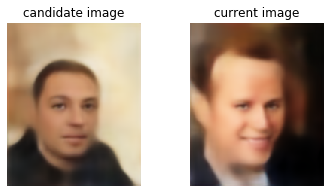

Is the candidate image better than current image? [y/n]
y


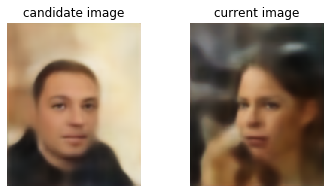

Is the candidate image better than current image? [y/n]
y


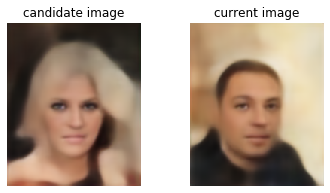

Is the candidate image better than current image? [y/n]
n


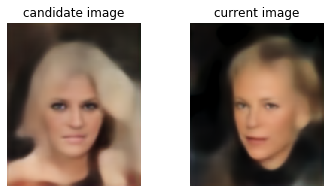

Is the candidate image better than current image? [y/n]
n


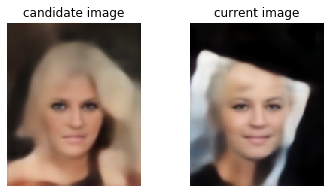

Is the candidate image better than current image? [y/n]
y


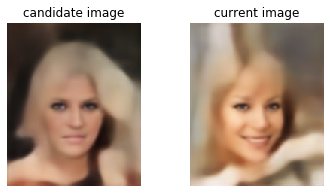

Is the candidate image better than current image? [y/n]
y


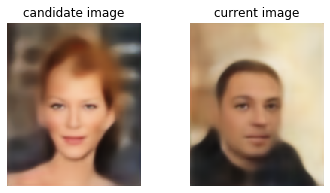

Is the candidate image better than current image? [y/n]
n


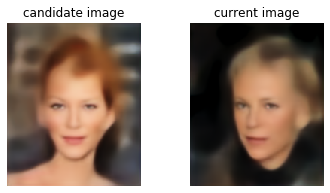

Is the candidate image better than current image? [y/n]
y


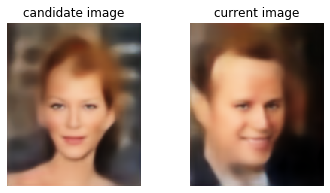

Is the candidate image better than current image? [y/n]
n


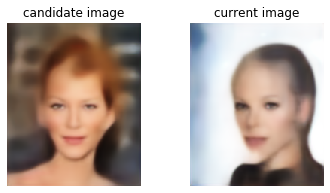

Is the candidate image better than current image? [y/n]
y


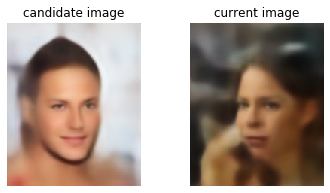

Is the candidate image better than current image? [y/n]
y


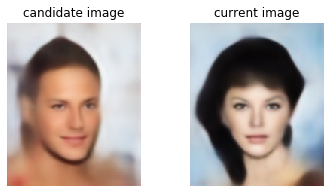

Is the candidate image better than current image? [y/n]
n


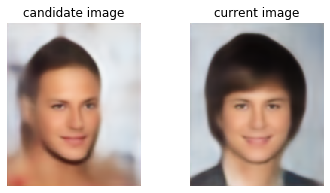

Is the candidate image better than current image? [y/n]
n


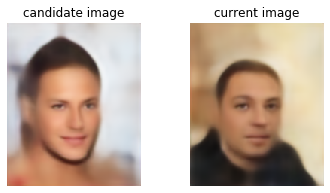

Is the candidate image better than current image? [y/n]
n


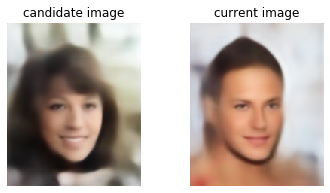

Is the candidate image better than current image? [y/n]
y


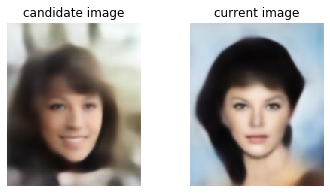

Is the candidate image better than current image? [y/n]
n


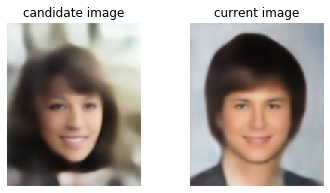

Is the candidate image better than current image? [y/n]
n


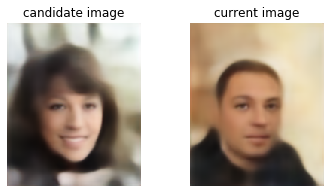

Is the candidate image better than current image? [y/n]
n


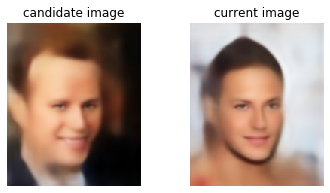

Is the candidate image better than current image? [y/n]
n


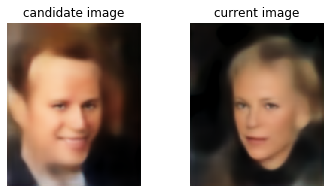

Is the candidate image better than current image? [y/n]
y


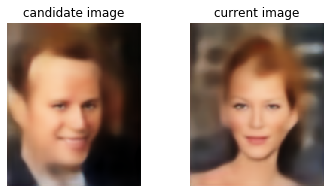

Is the candidate image better than current image? [y/n]
y


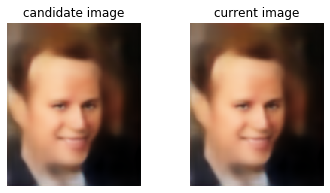

Is the candidate image better than current image? [y/n]
n


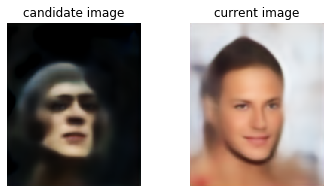

Is the candidate image better than current image? [y/n]
y


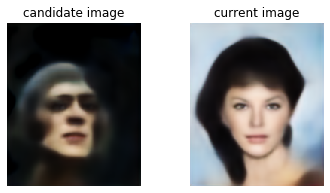

Is the candidate image better than current image? [y/n]
n


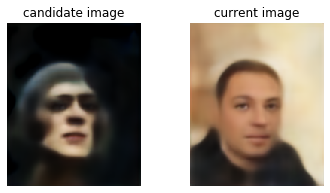

Is the candidate image better than current image? [y/n]
n


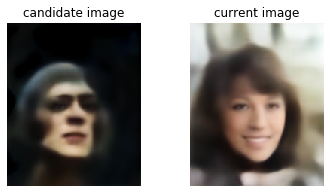

Is the candidate image better than current image? [y/n]
y


In [201]:
composit = FacialComposit(decoder, vae, 512)
composit.optimize()

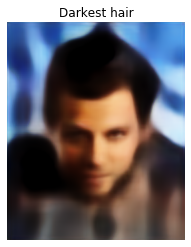

In [202]:
composit.draw_best('Darkest hair')

Not a bad prediction; the image generated does indeed have very dark hair.

## DCGAN

In [203]:
#create and compile DCGAN model
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, LeakyReLU,\
      BatchNormalization, Conv2DTranspose, Conv2D, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
from PIL import Image

def generator_model(latent_dim=100, leaky_alpha=0.2, init_stddev=0.02):

    g = Sequential()
    g.add(Dense(4*4*512, input_shape=(latent_dim,),
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(Reshape(target_shape=(4, 4, 512)))
    g.add(BatchNormalization())
    g.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    g.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same',
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(BatchNormalization())
    g.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    g.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', 
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(BatchNormalization())
    g.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    g.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', 
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(Activation('tanh'))
    g.summary()
    return g

  
def discriminator_model(leaky_alpha=0.2, init_stddev=0.02):
    d = Sequential()
    d.add(Conv2D(64, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev),
               input_shape=(32, 32, 3)))
    d.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    d.add(Conv2D(128, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev)))
    d.add(BatchNormalization())
    d.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    d.add(Conv2D(256, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev)))
    d.add(BatchNormalization())
    d.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    d.add(Flatten())
    d.add(Dense(1, kernel_initializer=RandomNormal(stddev=init_stddev)))
    d.add(Activation('sigmoid'))
    d.summary()
    return d

def DCGAN(sample_size=100):
    #generator
    g = generator_model(sample_size, 0.2, 0.02)

    #discriminator
    d = discriminator_model(0.2, 0.02)
    d.compile(optimizer=Adam(lr=0.001, beta_1=0.5), loss='binary_crossentropy')
    d.trainable = False
    
    #GAN
    gan = Sequential([g, d])
    gan.compile(optimizer=Adam(lr=0.0001, beta_1=0.5), loss='binary_crossentropy')
    
    return gan, g, d

In [204]:
#image processing and plotting functions

def load_image(filename, size=(32, 32)):
    img = plt.imread(filename)
    #crop
    rows, cols = img.shape[:2]
    crop_r, crop_c = 150, 150
    start_row, start_col = (rows - crop_r) // 2, (cols - crop_c) // 2
    end_row, end_col = rows - start_row, cols - start_row
    img = img[start_row:end_row, start_col:end_col, :]
    #resize
    img = np.array(Image.fromarray(img).resize(size))
    return img

def preprocess(x):
    return (x/255)*2-1

def deprocess(x):
    return np.uint8((x+1)/2*255)

def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])  

def show_losses(losses):
    losses = np.array(losses)  
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Validation Losses")
    plt.legend()
    plt.show()

def show_images(generated_images):
    n_images = len(generated_images)
    cols = 5
    rows = n_images//cols
    plt.figure(figsize=(8, 6))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 256)        


Epoch:   1/3 Discriminator Loss: 0.8369 Generator Loss: 2.1186


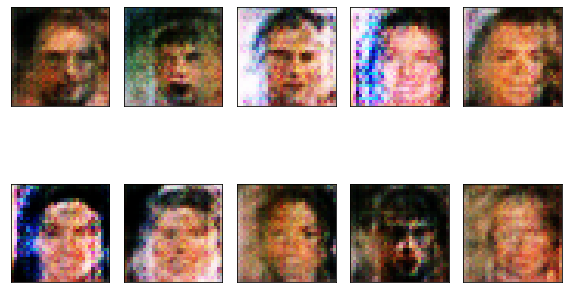

--------------- Epoch 2 ---------------



Epoch:   2/3 Discriminator Loss: 0.6576 Generator Loss: 1.4207


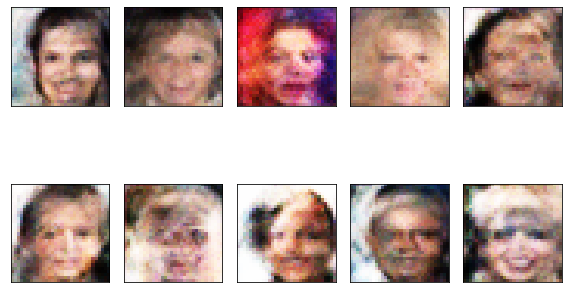

--------------- Epoch 3 ---------------



Epoch:   3/3 Discriminator Loss: 0.6683 Generator Loss: 1.7962


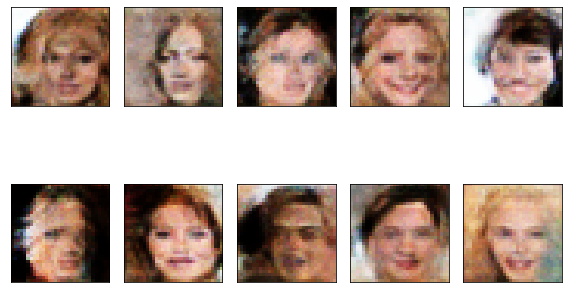

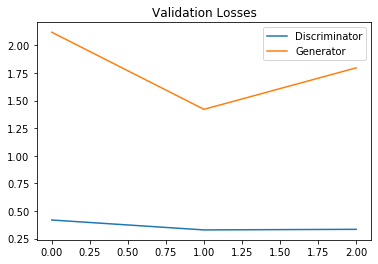

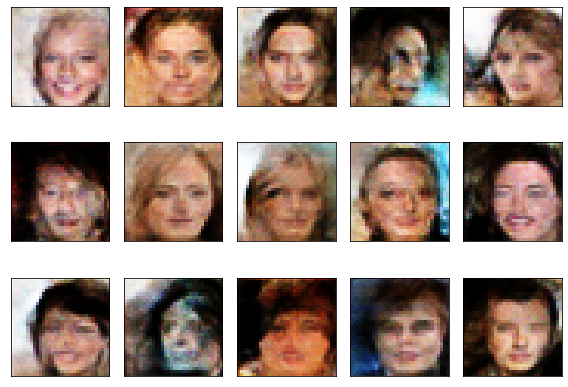

In [205]:
#function to train model
def train(sample_size=100, epochs=3, batch_size=128, eval_size=16, smooth=0.1, noise_dim=100):    
    batchCount=len(train_path)//batch_size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)
    
    #create a GAN, generator and discriminator
    gan, g, d = DCGAN(sample_size)
    
    losses = []    
    
    for e in range(epochs):
        print('-'*15, 'Epoch %d' % (e+1), '-'*15)
        for i in tqdm_notebook(range(batchCount)):
            
            path_batch = train_path[i*batch_size:(i+1)*batch_size]
            image_batch = np.array([preprocess(load_image(filename)) for filename in path_batch])
            
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            generated_images = g.predict_on_batch(noise)    #train discriminator on generated images
            d.trainable = True
            d.train_on_batch(image_batch, y_train_real*(1-smooth))
            d.train_on_batch(generated_images, y_train_fake) #train generator
            d.trainable = False
            g_loss=gan.train_on_batch(noise, y_train_real)
        
        #evaluate
        test_path = np.array(val_path)[np.random.choice(len(val_path), eval_size, replace=False)]
        x_eval_real = np.array([preprocess(load_image(filename)) for filename in test_path])        
        
        noise = np.random.normal(loc=0, scale=1, size=(eval_size, sample_size))
        x_eval_fake = g.predict_on_batch(noise)
        
        d_loss  = d.test_on_batch(x_eval_real, y_eval_real)
        d_loss += d.test_on_batch(x_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(noise, y_eval_real)
        
        losses.append((d_loss/2, g_loss))
  
        print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
            e+1, epochs, d_loss, g_loss))  
        
        show_images(x_eval_fake[:10])
    
    #show result
    show_losses(losses)
    show_images(g.predict(np.random.normal(loc=0, scale=1, size=(15, sample_size))))    
    return gan, g, d

gan, g, d = train()

Images generated look as though they have the potential to be much clearer than those generated by the VAE (which were blurry), even after only 3 epochs, but would require more training. However, from the validation loss plot, generator loss is increasing already, which suggests in order to improve output generated by the GAN, the model would benefit from being optimised more than increasing epochs.

## VAE-GAN 

The term VAE-GAN was first used by Larsen et. al. VAE-GAN models differentiate themselves from GANs in that their generators are VAEs.

In [6]:
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D
from keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from PIL import Image
import pandas as pd
from scipy.stats import norm
import keras
from keras.utils import np_utils, to_categorical
from keras import backend as K
import random
from keras import metrics
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Load image data

In [10]:
show_number = len(img_path)
datasetlist = []
for filename in (img_path[:show_number]):
    image = Image.open(os.path.join(filename))
    image = image.resize([64, 64], Image.ANTIALIAS)
    image = ((np.array(image) - 127.5 )/ 127.5)
    datasetlist.append(image)
    
dataset = np.array(datasetlist)
print(dataset.shape)

(202599, 64, 64, 3)


### Create and compile VAE-GAN

In [11]:
plotInternal = 50

latent_dim = 256
batch_size = 512
rows = 64
columns = 64
channel = 3
epochs = 50000

#optimisers
SGDop = SGD(lr=0.0003)
ADAMop = Adam(lr=0.0002)

#filters
filter_of_dis = 16
filter_of_decgen = 16
filter_of_encoder = 16

def sampling(args):
    mean, logsigma = args
    epsilon = K.random_normal(shape=(K.shape(mean)[0], latent_dim), mean=0., stddev=1.0)
    return mean + K.exp(logsigma / 2) * epsilon

def vae_loss(X , output , E_mean, E_logsigma):
    #compute average MSE error and scale it up
    reconstruction_loss = 2 * metrics.mse(K.flatten(X), K.flatten(output))
  
    #compute KL loss
    kl_loss = - 0.5 * K.sum(1 + E_logsigma - K.square(E_mean) - K.exp(E_logsigma), axis=-1)   
    total_loss = K.mean(reconstruction_loss + kl_loss)    
  
    return total_loss
  
def encoder(kernel, filter, rows, columns, channel):
    X = Input(shape=(rows, columns, channel))
    model = Conv2D(filters=filter, kernel_size=kernel, strides=2, padding='same')(X)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)    
    model = Conv2D(filters=filter*2, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)    
    model = Conv2D(filters=filter*4, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)    
    model = Conv2D(filters=filter*8, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)    
    model = Flatten()(model)    
    mean = Dense(latent_dim)(model)
    logsigma = Dense(latent_dim, activation='tanh')(model)
    latent = Lambda(sampling, output_shape=(latent_dim,))([mean, logsigma])
    meansigma = Model([X], [mean, logsigma, latent])
    meansigma.compile(optimizer=SGDop, loss='mse')
    return meansigma

def decgen(kernel, filter, rows, columns, channel):
    X = Input(shape=(latent_dim,))    
    model = Dense(2*2*256)(X)
    model = Reshape((2, 2, 256))(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = Activation('relu')(model)    
    model = Conv2DTranspose(filters=filter*8, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = Activation('relu')(model)
    
    model = Conv2DTranspose(filters=filter*4, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = Activation('relu')(model)    
    model = Conv2DTranspose(filters=filter*2, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = Activation('relu')(model)    
    model = Conv2DTranspose(filters=filter, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = Activation('relu')(model)    
    model = Conv2DTranspose(filters=channel, kernel_size=kernel, strides=2, padding='same')(model)
    model = Activation('tanh')(model)    
    model = Model(X, model)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.5), metrics=['accuracy'])
    return model

def discriminator(kernel, filter, rows, columns, channel):
    X = Input(shape=(rows, columns, channel))    
    model = Conv2D(filters=filter*2, kernel_size=kernel, strides=2, padding='same')(X)
    model = LeakyReLU(alpha=0.2)(model)    
    model = Conv2D(filters=filter*4, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)    
    model = Conv2D(filters=filter*8, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)    
    model = Conv2D(filters=filter*8, kernel_size=kernel, strides=2, padding='same')(model)
    dec = BatchNormalization(epsilon=1e-5)(model)
    dec = LeakyReLU(alpha=0.2)(dec)
    dec = Flatten()(dec)
    dec = Dense(1, activation='sigmoid')(dec)    
    output = Model(X, dec)
    output.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
                   
    return output  

def VAEGAN(decgen,discriminator):
    #generator
    g = decgen    
    #discriminator
    d = discriminator
    d.trainable = False
    #GAN
    gan = Sequential([g, d])
    
    gan.compile(optimizer=Adam(lr=0.0001, beta_1=0.5), loss='binary_crossentropy')
    return g, d, gan

In [23]:
#functions to plot generated images
def get_image(image_path, width, height, mode):
    image = Image.open(image_path)
    return np.array(image.convert(mode))

def show_imgs(generator):
    row=3
    col = 5
    noise = np.random.normal(0, 1, (row*col, latent_dim))
    gen_imgs = generator.predict(noise)

    #rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(row, col)
    cnt = 0

    for i in range(row):
        for j in range(col):
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1

    plt.show()

In [13]:
#parameters of generator affected by both the GAN and VAE training

G, D, GAN = VAEGAN(decgen(5, filter_of_decgen, rows, columns, channel),discriminator(5, filter_of_dis, rows, columns, channel))

#encoder
E = encoder(5, filter_of_encoder, rows, columns, channel)
print("This is the summary for encoder:")
E.summary()


#generator/decoder
print("This is the summary for dencoder/generator:")
G.summary()


#discriminator
print("This is the summary for discriminator:")
D.summary()


D_fixed = discriminator(5, filter_of_dis, rows, columns, channel)
D_fixed.compile(optimizer=SGDop, loss='mse')

#gan
print("This is the summary for GAN:")
GAN.summary()

#VAE
X = Input(shape=(rows, columns, channel))

E_mean, E_logsigma, Z = E(X)

output = G(Z)

VAE = Model(X, output)
VAE.add_loss(vae_loss(X, output, E_mean, E_logsigma))
VAE.compile(optimizer=SGDop)

print("This is the summary for vae:")
VAE.summary()

This is the summary for encoder:
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 16)   1216        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 32, 32, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 32, 32, 16)   0           batch_normalization_9[0][0]      
___________________________________________________________

This is the summary for vae:
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
model_3 (Model)              [(None, 256), (None, 256) 1320288   
_________________________________________________________________
model_1 (Model)              (None, 64, 64, 3)         1354595   
Total params: 2,674,883
Trainable params: 2,673,411
Non-trainable params: 1,472
_________________________________________________________________


### Train the VAE-GAN

The training of the discriminator is emphasised in the first half of the training process and the generator is trained more in the second half in order to improve the quality of the output images.

In [14]:
#train model
dLoss=[]
gLoss=[]
GLoss = 1
GlossEnc = 1
GlossGen = 1
Eloss = 1

halfbatch_size = int(batch_size*0.5)

for epoch in tqdm(range(epochs)):
    if epoch < int(epochs*0.5):
        noise = np.random.normal(0, 1, (halfbatch_size, latent_dim))
        index = np.random.randint(0,dataset.shape[0], halfbatch_size)
        images = dataset[index]  

        latent_vect = E.predict(images)[0]
        encImg = G.predict(latent_vect)
        fakeImg = G.predict(noise)

        D.Trainable = True
        DlossTrue = D.train_on_batch(images, np.ones((halfbatch_size, 1)))
        DlossEnc = D.train_on_batch(encImg, np.ones((halfbatch_size, 1)))       
        DlossFake = D.train_on_batch(fakeImg, np.zeros((halfbatch_size, 1)))
        
        DLoss=np.add(DlossTrue,DlossEnc)
        DLoss=np.add(DLoss,DlossFake)*0.33
        D.Trainable = False

        cnt = epoch

        while cnt > 3:
            cnt = cnt - 4

        if cnt == 0:
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            index = np.random.randint(0,dataset.shape[0], batch_size)
            images = dataset[index]  
            latent_vect = E.predict(images)[0]     
            
            GlossEnc = GAN.train_on_batch(latent_vect, np.ones((batch_size, 1)))
            GlossGen = GAN.train_on_batch(noise, np.ones((batch_size, 1)))
            Eloss = VAE.train_on_batch(images, None)   
            GLoss=np.add(GlossEnc,GlossGen)
            GLoss=np.add(GLoss,Eloss)*0.33
        dLoss.append([epoch,DLoss[0]]) 
        gLoss.append([epoch,GLoss])
    
    elif epoch >= int(epochs*0.5):
        cnt = epoch
        while cnt > 3:
            cnt = cnt - 4

        if cnt == 0:
            noise = np.random.normal(0, 1, (halfbatch_size, latent_dim))
            index = np.random.randint(0,dataset.shape[0], halfbatch_size)
            images = dataset[index]  

            latent_vect = E.predict(images)[0]
            encImg = G.predict(latent_vect)
            fakeImg = G.predict(noise)

            D.Trainable = True
            DlossTrue = D.train_on_batch(images, np.ones((halfbatch_size, 1)))
            DlossFake = D.train_on_batch(fakeImg, np.zeros((halfbatch_size, 1)))

            DLoss=np.add(DlossTrue,DlossFake)*0.5

            D.Trainable = False

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        index = np.random.randint(0,dataset.shape[0], batch_size)
        images = dataset[index]  
        latent_vect = E.predict(images)[0]
        
        GlossEnc = GAN.train_on_batch(latent_vect, np.ones((batch_size, 1)))
        GlossGen = GAN.train_on_batch(noise, np.ones((batch_size, 1)))
        Eloss = VAE.train_on_batch(images, None)   
        GLoss=np.add(GlossEnc,GlossGen)
        GLoss=np.add(GLoss,Eloss)*0.33
    
        dLoss.append([epoch,DLoss[0]]) 
        gLoss.append([epoch,GLoss])

    #if epoch % plotInternal == 0 and epoch!=0:
     #   show_imgs(G)


    dLossArr= np.array(dLoss)
    gLossArr = np.array(gLoss)
    
    chk = epoch

    while chk > 50:
        chk = chk - 51

    if chk == 0:
        D.save_weights('VAEGAN_discriminator.h5')
        G.save_weights('VAEGAN_generator.h5')
        E.save_weights('VAEGAN_encoder.h5')

        
    #if epoch%20 == 0:    
     #   print("epoch:", epoch + 1,"  ", "DislossTrue loss:",DlossTrue[0],"D accuracy：",100* DlossTrue[1], "DlossFake loss:", DlossFake[0],"GlossEnc loss:",
      #    GlossEnc, "GlossGen loss:",GlossGen, "Eloss loss:",Eloss)

print('Training done,saving weights')
D.save_weights('VAEGAN_discriminator.h5')
G.save_weights('VAEGAN_generator.h5')
E.save_weights('VAEGAN_encoder.h5')

100%|██████████| 50000/50000 [30:39:34<00:00,  2.21s/it]    

Training done,saving weights


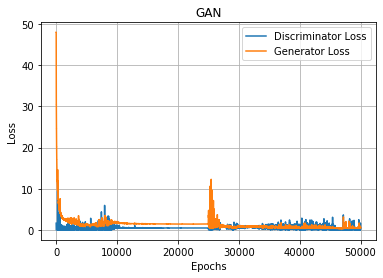

Complete


In [15]:
#plot losses vs epochs
plt.plot(dLossArr[:, 0], dLossArr[:, 1], label="Discriminator Loss")
plt.plot(gLossArr[:, 0], gLossArr[:, 1], label="Generator Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN')
plt.grid(True)
plt.show()
print('Complete')

### Generate images with the trained VAE-GAN

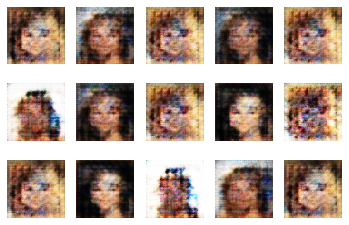

In [24]:
show_imgs(G)

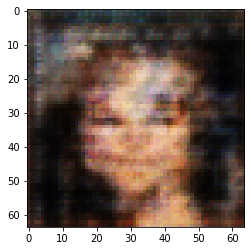

(<matplotlib.image.AxesImage at 0x7f8078c44810>, None)

In [25]:
noise = np.random.normal(0, 1, (batch_size, 256))
image = G.predict(noise)
image = np.uint8(image * 127.5 + 127.5)
plt.imshow(image[0]), plt.show()